<a href="https://colab.research.google.com/github/iamDavidLai/Static_Gestures_Recognition/blob/main/Gesture_recog_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!ls      # 目前的資料夾
!pwd      # 當前目錄
!nvidia-smi  # 查看GPU

drive		my_gesture_7_model_weights.h5  sample_data
my_gesture_7-2	my_gesture_7_structure.json
/content
Fri Nov 27 04:51:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------

###*務必確認 Keras 與 tensorflow 兩個版本之間的相容性, 否則訓練過程將會發生難以判斷的錯誤。*

#### IMPORTANT!     Checking library compatibility is necessary.


https://docs.floydhub.com/guides/environments/

In [ ]:
!pip install keras==2.3.1
!pip install tensorflow==2.2.0 

# !pip install -q keras==2.3.1
# !pip install -q tensorflow==2.2.0

## 確認相容性: Keras 2.3.1 & tensorflow 2.2.0 

In [ ]:
import keras
import tensorflow as tf
print("keras:", keras.__version__)
print("tensorflow:", tf.__version__)

Using TensorFlow backend.


keras: 2.3.1
tensorflow: 2.2.0


In [ ]:
!unzip "/content/drive/My Drive/Colab Notebooks/zip/my_gesture_7-2.zip" -d "/content"

In [ ]:
import os
# import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import  optimizers

print(os.listdir("./my_gesture_7-2"))

['validation', 'train', 'test']


In [ ]:
# setting directories
train_dir = "./my_gesture_7-2/train"
val_dir = "./my_gesture_7-2/validation"
test_dir = "./my_gesture_7-2/test"

In [ ]:
epochs = 30 # num of epochs
output_size = len(os.listdir(train_dir))  # num of gestures (classification include none), = num of the last Dense layer units
print(output_size)

8


## Using Data Augmentation

https://keras.io/api/preprocessing/image/

https://keras.io/zh/preprocessing/image/

https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True  # Do not vertical_flip, because real things almost has not upside down type.
)

"""
IMPORTANT!
test & validation data should not be augmentation.
"""
test_datagen = ImageDataGenerator(rescale= 1./255) 

train_generator = train_datagen.flow_from_directory(
  train_dir,          # it should contain subdirectories, 子目錄內要包含圖片分類 each containing images for a class. Otherwise, the directory structure is ignored.
  target_size = (256,256),  # Your image dimension
  batch_size = 32,      # Size of the batches of data. 每一次處理多少數據(圖像) default value, 
  class_mode = "categorical", # will return 2D One-hot Encoding labels 
  color_mode ="grayscale"   # We use binary images that will be converted to have 1 channel.
)

val_generator = test_datagen.flow_from_directory(
  val_dir,
  target_size = (256,256),
  batch_size = 32,      
  class_mode = "categorical",
  color_mode ="grayscale"
)

Found 8031 images belonging to 8 classes.
Found 4017 images belonging to 8 classes.


In [ ]:
def create_model(output_size):
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(256,256,1)))  # image dimension (width, height, channel)
  model.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
  model.add(MaxPooling2D(pool_size=2))

  model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
  model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
  model.add(MaxPooling2D(pool_size=2))

  model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
  model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))   
  model.add(MaxPooling2D(pool_size=2))

  model.add(Flatten())
  model.add(Dropout(rate=0.5))

  model.add(Dense(512, activation="relu"))

  """
  Problem type: Multiclass, single-label classification
  Last-layer actication: softmax
  Loss function: categorical_crossentropy
  learning rate = 1e-4 = 0.0001
  """
  model.add(Dense(units=output_size, activation="softmax"))
  model.compile(optimizer = optimizers.adam(lr=1e-4), loss ="categorical_crossentropy", metrics=["accuracy"])
  return model

In [ ]:
model = create_model(output_size)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 252, 252, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 122, 122, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 59, 59, 128)      

## Training Model
fit_generator() for ImageDataGenerator()

http://yanci-elegant-life.blogspot.com/2019/09/fitgeneratorfitgenerator-tensorflow.html

https://blog.csdn.net/learning_tortosie/article/details/85243310

In [ ]:
history = model.fit_generator(
  train_generator,
  steps_per_epoch = output_size*1000/32,     # 8*1000/32 = 250
  epochs = epochs,
  validation_data = val_generator,
  validation_steps = output_size*500/32
)

Epoch 1/30
250/250 [==============================] - 69s 274ms/step - loss: 1.1449 - accuracy: 0.5514 - val_loss: 0.7641 - val_accuracy: 0.7920
Epoch 2/30
250/250 [==============================] - 64s 256ms/step - loss: 0.5997 - accuracy: 0.7735 - val_loss: 0.4388 - val_accuracy: 0.8740
Epoch 3/30
250/250 [==============================] - 64s 254ms/step - loss: 0.4173 - accuracy: 0.8517 - val_loss: 0.1230 - val_accuracy: 0.9536
Epoch 4/30
250/250 [==============================] - 64s 255ms/step - loss: 0.3309 - accuracy: 0.8842 - val_loss: 0.0849 - val_accuracy: 0.9797
Epoch 5/30
250/250 [==============================] - 64s 256ms/step - loss: 0.2840 - accuracy: 0.9059 - val_loss: 0.0452 - val_accuracy: 0.9566
Epoch 6/30
250/250 [==============================] - 64s 256ms/step - loss: 0.2454 - accuracy: 0.9159 - val_loss: 0.1906 - val_accuracy: 0.9629
Epoch 7/30
250/250 [==============================] - 64s 255ms/step - loss: 0.2061 - accuracy: 0.9347 - val_loss: 0.2007 - val_ac

## Loading The Model

In [ ]:
model = load_model("/content/drive/My Drive/Colab Notebooks/zip/my_gesture_7_model.h5")

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 252, 252, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 122, 122, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 59, 59, 128)      

## Evaluating The Model

In [ ]:
test_generator = test_datagen.flow_from_directory(
  test_dir,
  target_size = (256,256),
  batch_size = 32,
  class_mode = "categorical",
  color_mode = "grayscale"
)

Found 4026 images belonging to 8 classes.


In [ ]:
test_loss, test_acc = model.evaluate_generator(
    test_generator,
    steps = output_size*500/32,
    verbose=1
    )
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

125/125 [==============================] - 7s 57ms/step
Test Loss: 0.004316849168390036
Test Accuracy: 0.9947500228881836


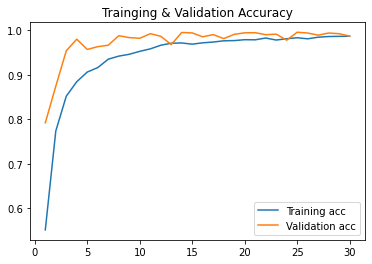

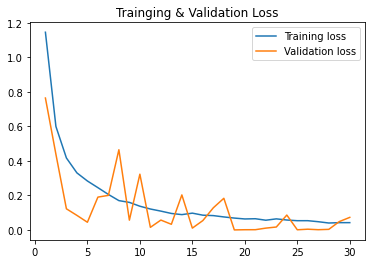

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, label = "Training acc")
plt.plot(epochs, val_acc, label = "Validation acc")
plt.title("Trainging & Validation Accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, label = "Training loss")
plt.plot(epochs, val_loss, label = "Validation loss")
plt.title("Trainging & Validation Loss")
plt.legend()

## Saving result: All Structure

使用 model.save(filepath) 將 Keras 模型保存到單個 HDF5 文件中，該文件將包含：

* 模型的結構，允許重新創建模型
* 模型的權重
* 訓練配置項（損失函數，優化器）
* 優化器狀態，允許準確地從你上次結束的地方繼續訓練。

透過 keras.models.load_model(filepath) 重新實例化模型。

model.load_weights(filepath, by_name=False)

預設模型結構是不變的, 如果想將權重載入不同的模型(部分層相同)，透過by_name=True來載入名字相同的層的權重

In [ ]:
model.save("my_gesture_7_model.h5")

## Saving result: Weights
將模型權重儲存為HDF5文件


In [ ]:
model.save_weights("my_gesture_7_model_weights.h5")

In [ ]:
# load the weights(parameters), not included model
# model.load_weights("my_gesture_7_model_weights.h5")

## Saving result: Structure of Model

如果只需要保存模型的結構，而非其權重或訓練配置項，

#### **保存為 JSON:** 
json_string = model.to_json()

#### **保存為 YAML:** 
yaml_string = model.to_yaml()

In [ ]:
import json
model_structure = model.to_json()
with open("my_gesture_7_structure.json", "w") as json_file:
    json.dump(model_structure, json_file)

In [ ]:
# from keras.models import model_from_json
# model = model_from_json("json_string")